# Применение логистической регрессии для решения задачи классификации

# Описание набора данных

Данный набор содержит информацию о пассажирах корабля «Титаник», затонувшего в ночь на 15-е апреля 1912 года. Некоторое количество пассажиров спаслось, чему способствовало множество различных факторов, включая их пол, возраст, на какой палубе находилась их кабина, социальный статус, и т.д.

Набор данных состоит из различных признаков, описывающих информацию о пассажирах. Каждая строка таблицы — отдельный пассажир, вся информация о нем содержится в его строке.

Описание датасета:
- **Survived** (целевой признак): выжил ли пассажир (0 = Нет, 1 = Да);
- **Pclass**: класс каюты (1 = 1st, 2 = 2nd, 3 = 3rd);
- **Sex**: пол (female или male)
- **Age**: возраст в годах
- **SibSp**: количество братьев, сестёр (в том числе сводных) и супругов на борту
- **Parch**: количество детей и родителей на борту
- **Ticket**: номер билета
- **Fare**: стоимость проезда пассажира
- **Cabin**: номер каюты
- **Embarked**: порт посадки пассажира (C = Cherbourg, Q = Queenstown, S = Southampton).

Необходимо решить задачу классификации и научиться предсказывать целовой признак **Survived** — выживет ли пассажир — по соответсвующим ему нецелевым признакам.


# Подготовка и первичный анализ данных

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

Количество пропущенных значений поля <code>age</code>:

In [ ]:
df = pd.read_csv('titanic_train.csv')
test = pd.read_csv('titanic_reserved.csv')
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,3,1,"Smyth, Miss. Julia",female,NaN,0,0,335432,7.7333,NaN,Q,NaN
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,7.7500,NaN,Q,"Co Clare, Ireland Washington, DC"
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,0,0,2688,7.2292,NaN,C,NaN
3,3,0,"Vovk, Mr. Janko",male,22.0,0,0,349252,7.8958,NaN,S,NaN
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,0,0,345778,9.5000,NaN,S,NaN


In [ ]:
df['age'].isna().sum()

199

Доля выживших

In [ ]:
df['survived']

proportion = df['survived'].value_counts(normalize=True)[1]
proportion

0.382262996941896

Долю пропущенных значений в рамках каждого признака и уберем те признаков, где доля пропусков больше трети.

In [ ]:
missing_fractions = df.isnull().sum() / len(df)
columns_to_drop = missing_fractions[missing_fractions > 0.33].index

df = df.drop(columns=columns_to_drop)
df = df.drop(columns=['ticket'])


In [ ]:
test = test.drop(columns=columns_to_drop)
test = test.drop(columns=['ticket'])

Колонки <code>sibsp</code> и <code>parch</code> по сути отвечают за размер семьи. Заменим эти две колонки на колонку <code>fam_size</code>, значения которой будут вычисляться как сумма соответствующих значений в колонках <code>sibsp</code> и <code>parch</code>.

In [ ]:
df['fam_size'] = df['sibsp'] + df['parch']
df = df.drop(columns=['sibsp', 'parch'])

,pclass,survived,name,sex,age,fare,embarked,fam_size
0,3,1,"Smyth, Miss. Julia",female,NaN,7.7333,Q,0
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,7.7500,Q,0
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,7.2292,C,0
3,3,0,"Vovk, Mr. Janko",male,22.0,7.8958,S,0
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,9.5000,S,0
...,...,...,...,...,...,...,...,...
976,3,1,"Howard, Miss. May Elizabeth",female,NaN,8.0500,S,0
977,3,1,"Dorking, Mr. Edward Arthur",male,19.0,8.0500,S,0
978,2,0,"Gillespie, Mr. William Henry",male,34.0,13.0000,S,0
979,3,0,"Barton, Mr. David John",male,22.0,8.0500,S,0


In [ ]:
df['fam_size'].mean()

0.8664627930682977

Полученный датасет будем называть **исходным** (выброшенные на этом этапе признаки не нужно возвращать ни на одном из последующих этапов выполнения задания). Вычислите полученное число предикторов.

На основе имеющейся статистики оценим вероятность выжить если пассажир -- представитель определенной категории (указана в вашем индивидуальном задании)

In [ ]:
survival_probability = df[(df['sex'] == 'male') & (df['pclass'] == 3)]['survived'].mean()

print(f"The probability of survival for a male passenger in Pclass 3 is: {survival_probability}")

Гистограммы выжиших и невыживших по возрастам.

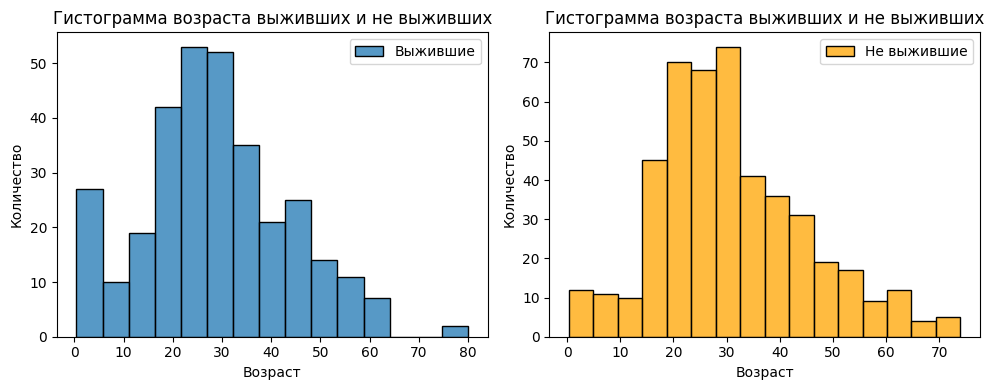

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.histplot(df[df['survived'] == 1]['age'], label='Выжившие')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.title('Гистограмма возраста выжившихх')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(df[df['survived'] == 0]['age'], label='Не выжившие', color='orange')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.title('Гистограмма возраста не выживших')
plt.legend()

plt.tight_layout()
plt.show()

# Модель на основе числовых признаков

## Удаление строк с пропусками

В качестве базовой модели имеет смысл построить модель с минимальными трудозатратами.

Из исходного датасета удалим все категориальные признаки, а также строки, содержащие пропуски.

Обучим модель <code>LogisticRegression()</code> <b> на тренировочных данных, оценим на тестовых.

In [ ]:
df1 = df.drop(columns=['name','sex', 'embarked'])
df1 = df1.dropna()
df1

,pclass,survived,age,fare,fam_size
2,3,1,38.0,7.2292,0
3,3,0,22.0,7.8958,0
4,3,0,16.0,9.5000,0
5,3,1,29.0,7.7500,0
7,1,0,25.0,26.0000,0
...,...,...,...,...,...
975,2,0,19.0,10.5000,0
977,3,1,19.0,8.0500,0
978,2,0,34.0,13.0000,0
979,3,0,22.0,8.0500,0


In [ ]:
from sklearn.model_selection import train_test_split

X = df1.drop('survived', axis=1)
y = df1['survived']

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=23, stratify=y)

In [ ]:
reg = LogisticRegression(random_state=23, max_iter=1000)
reg.fit(train_x, train_y)

y_pred = reg.predict(test_x)
f1 = f1_score(test_y, y_pred)

print("F1-метрика модели на тестовых данных:", f1)

F1-метрика модели на тестовых данных: 0.48


## Заполненим пропуски средним

Качество полученной модели оставляет желать лучшего. Имеет смысл попробовать заполнить пропуски.

In [ ]:
df['age'] = df['age'].fillna(df['age'].mean())
df['pclass'] = df['pclass'].fillna(df['pclass'].mean())
df['fare'] = df['fare'].fillna(df['fare'].mean())
df['fam_size'] = df['fam_size'].fillna(df['fam_size'].mean())

# Now, repeat the process from the previous code block
df1 = df.drop(columns=['name','sex', 'embarked'])

X = df1.drop('survived', axis=1)
y = df1['survived']

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=23, stratify=y)
reg = LogisticRegression(random_state=23, max_iter=1000)
reg.fit(train_x, train_y)

y_pred = reg.predict(test_x)
f1 = f1_score(test_y, y_pred)

print("F1-метрика модели на тестовых данных (с заполнением пропусков средним):", f1)

F1-метрика модели на тестовых данных (с заполнением пропусков средним): 0.4881889763779528


## Заполнение пропусков на основе обращения


Очевидно, что заполнение пропусков в колонке <code>age</code> средним — не самая разумная идея. Возможно, стоит выполнить эту процедуру как-то более интеллектуально, например, с оглядкой на обращение к человеку.

Можно заметить, что исходный датасет в столбце <code>name</code> содержит информацию о социальном статусе пассажира, а именно присутсвуют обращения <code>Mr., Mrs., Dr.</code> и т.д. На основе этой информации можно попробовать сделать предположение о возрасте пассажира.

In [ ]:
df2 = df.drop(columns=['sex', 'embarked'])
df2

,pclass,survived,name,sex,age,fare,embarked,fam_size
0,3,1,"Smyth, Miss. Julia",female,NaN,7.7333,Q,0
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,7.7500,Q,0
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,7.2292,C,0
3,3,0,"Vovk, Mr. Janko",male,22.0,7.8958,S,0
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,9.5000,S,0
...,...,...,...,...,...,...,...,...
976,3,1,"Howard, Miss. May Elizabeth",female,NaN,8.0500,S,0
977,3,1,"Dorking, Mr. Edward Arthur",male,19.0,8.0500,S,0
978,2,0,"Gillespie, Mr. William Henry",male,34.0,13.0000,S,0
979,3,0,"Barton, Mr. David John",male,22.0,8.0500,S,0


In [ ]:
df2 = df

df2['honorific'] = df2['name'].str.extract(' ([A-Za-z]+)\.', expand=False)

unique_honorifics_count = df2['honorific'].nunique()

print(f"Number of unique honorifics: {unique_honorifics_count}")

df2['honorific'].unique()


Number of unique honorifics: 14


array(['Miss', 'Mrs', 'Mr', 'Master', 'Mlle', 'Rev', 'Ms', 'Col', 'Dona',
       'Dr', 'Countess', 'Major', 'Don', 'Capt'], dtype=object)

In [ ]:
test['honorific'] = test['name'].str.extract(' ([A-Za-z]+)\.', expand=False)

unique_honorifics_count = test['honorific'].nunique()

print(f"Number of unique honorifics: {unique_honorifics_count}")

test['honorific'].unique()

Number of unique honorifics: 12


array(['Mr', 'Miss', 'Master', 'Mrs', 'Sir', 'Major', 'Rev', 'Lady',
       'Col', 'Mme', 'Jonkheer', 'Dr'], dtype=object)

Выполним следующие замены:

<code>Mr</code> $\leftarrow$ <code>['Rev', 'Col', 'Dr', 'Major', 'Don', 'Capt']</code>

<code>Mrs</code> $\leftarrow$ <code> ['Dona', 'Countess']</code>

<code>Miss</code> $\leftarrow$ <code> ['Mlle', 'Ms']</code>

In [ ]:
import pandas as pd

# Replace honorifics as specified
replacements = {
    'Mr': ['Rev', 'Col', 'Dr', 'Major', 'Don', 'Capt'],
    'Mrs': ['Dona', 'Countess'],
    'Miss': ['Mlle', 'Ms']
}

for new, old in replacements.items():
    for old in old:
        df2['honorific'] = df2['honorific'].replace(old, new)

df2['honorific'].unique()

array(['Miss', 'Mrs', 'Mr', 'Master'], dtype=object)

In [ ]:
mean_age_by_honorific = df2.groupby('honorific')['age'].mean()

def fill_missing_age(row):
    if pd.isnull(row['age']):
        return mean_age_by_honorific.get(row['honorific'], df2['age'].mean())
    return row['age']

df2['age'] = df2.apply(fill_missing_age, axis=1)

df3 = df2.drop(columns=['name', 'honorific'])
df3 = df3.dropna()
df3

,pclass,survived,sex,age,fare,embarked,fam_size
0,3,1,female,22.005765,7.7333,Q,0
1,3,1,female,22.005765,7.7500,Q,0
2,3,1,female,38.000000,7.2292,C,0
3,3,0,male,22.000000,7.8958,S,0
4,3,0,male,16.000000,9.5000,S,0
...,...,...,...,...,...,...,...
976,3,1,female,22.005765,8.0500,S,0
977,3,1,male,19.000000,8.0500,S,0
978,2,0,male,34.000000,13.0000,S,0
979,3,0,male,22.000000,8.0500,S,0


In [ ]:
X = df3.drop('survived', axis=1)
y = df3['survived']

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=23, stratify=y)
reg = LogisticRegression(random_state=23, max_iter=1000)
reg.fit(train_x, train_y)

y_pred = reg.predict(test_x)
f1 = f1_score(test_y, y_pred)

print("F1-метрика модели на тестовых данных (с заполнением пропусков по обращению):", f1)

F1-метрика модели на тестовых данных (с заполнением пропусков по обращению): 0.484375


# Модель с использование категориальных признаков

 <code>one-hot</code> кодировние нечисловых признаков, например, с помощью <code>pd.get_dummies(drop_first=True)</code>.

In [ ]:
df2 = df

mean_age_by_honorific = df2.groupby('honorific')['age'].mean()

def fill_missing_age(row):
    if pd.isnull(row['age']):
        return mean_age_by_honorific.get(row['honorific'], df2['age'].mean())
    return row['age']

df2['age'] = df2.apply(fill_missing_age, axis=1)

df2 = df2.drop(columns=['name', 'honorific'])
df2 = df2.dropna()

columns_to_encode = ['sex', 'embarked']
df_encoded = pd.get_dummies(df2, columns=columns_to_encode, drop_first=True)
df_encoded

,pclass,survived,age,fare,fam_size,sex_male,embarked_Q,embarked_S
0,3,1,22.005765,7.7333,0,False,True,False
1,3,1,22.005765,7.7500,0,False,True,False
2,3,1,38.000000,7.2292,0,False,False,False
3,3,0,22.000000,7.8958,0,True,False,True
4,3,0,16.000000,9.5000,0,True,False,True
...,...,...,...,...,...,...,...,...
976,3,1,22.005765,8.0500,0,False,False,True
977,3,1,19.000000,8.0500,0,True,False,True
978,2,0,34.000000,13.0000,0,True,False,True
979,3,0,22.000000,8.0500,0,True,False,True


In [ ]:
X = df_encoded.drop('survived', axis=1)
y = df_encoded['survived']

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=23, stratify=y)
reg = LogisticRegression(random_state=23, max_iter=1000)
reg.fit(train_x, train_y)

y_pred = reg.predict(test_x)
f1 = f1_score(test_y, y_pred)

print("F1-метрика модели на тестовых данных (с заполнением пропусков по обращению):", f1)

F1-метрика модели на тестовых данных (с заполнением пропусков по обращению): 0.6814814814814815
